In [140]:
#############
# LIBRARIES #
#############

from get_strava_data import my_data, process_data # Functions to retrive data using strava api and process for visualizations
from fit2gpx import StravaConverter

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import plotly.io as pio
pio.renderers.default = 'notebook_connected'


In [141]:
##########################
# Getting all activities #
##########################

my_data_df = my_data()
processed_data = process_data(my_data_df)

# Saving data to csv
processed_data.to_csv('./data/processed_data.csv', index=False)

Getting data...
Requesting page 1...
<Response [200]>
Requesting page 2...
<Response [200]>
Requesting page 3...
<Response [200]>
Requesting page 4...
<Response [200]>
Data retrieved successfully!


In [142]:
# Reading data from csv
processed_data = pd.read_csv('./data/processed_data.csv')
processed_data.head()

,name,distance,moving_time,elapsed_time,total_elevation_gain,type,id,start_date_local,achievement_count,kudos_count,...,average_watts,max_watts,weighted_average_watts,kilojoules,elev_high,year,month,day,weekday,hour
0,HIIT,0.0,0.5,0.5,0.0,Workout,6967778843,2022-04-11 21:40:51+00:00,0,0,...,NaN,NaN,NaN,NaN,NaN,2022,4,11,Monday,21
1,Afternoon Ride,18.1,1.1,1.2,167.3,Ride,6962213592,2022-04-10 12:52:32+00:00,24,10,...,143.0,522.0,153.0,555.6,71.5,2022,4,10,Sunday,12
2,Fun with the kiddos,4.0,0.6,2.2,7.5,Ride,6956840241,2022-04-09 14:47:48+00:00,1,7,...,37.2,NaN,NaN,78.3,14.8,2022,4,9,Saturday,14
3,Monterey - Butters,20.4,1.5,1.6,1355.0,Ride,6955866591,2022-04-09 09:55:44+00:00,28,15,...,140.9,1007.0,166.0,746.4,1154.2,2022,4,9,Saturday,9
4,Evening Activity,0.0,0.9,0.9,0.0,WeightTraining,6951585517,2022-04-08 18:37:40+00:00,0,1,...,NaN,NaN,NaN,NaN,NaN,2022,4,8,Friday,18


In [143]:
processed_data.columns

Index(['name', 'distance', 'moving_time', 'elapsed_time',
       'total_elevation_gain', 'type', 'id', 'start_date_local',
       'achievement_count', 'kudos_count', 'comment_count', 'photo_count',
       'trainer', 'average_speed', 'max_speed', 'average_heartrate',
       'max_heartrate', 'pr_count', 'total_photo_count', 'suffer_score',
       'average_cadence', 'average_temp', 'average_watts', 'max_watts',
       'weighted_average_watts', 'kilojoules', 'elev_high', 'year', 'month',
       'day', 'weekday', 'hour'],
      dtype='object')

In [144]:
streamlit_df = processed_data[['start_date_local', 'name', 'type', 'moving_time', 'distance', 'total_elevation_gain', 'average_speed', 'average_cadence', 'average_watts', 'average_heartrate', 'suffer_score']].copy()
streamlit_df['start_date_local'] = pd.to_datetime(streamlit_df['start_date_local'])
streamlit_df['start_date_local'] = streamlit_df['start_date_local'].dt.strftime('%m-%d-%Y')
streamlit_df

,start_date_local,name,type,moving_time,distance,total_elevation_gain,average_speed,average_cadence,average_watts,average_heartrate,suffer_score
0,04-11-2022,HIIT,Workout,0.5,0.0,0.0,0.000,NaN,NaN,151.7,55.0
1,04-10-2022,Afternoon Ride,Ride,1.1,18.1,167.3,7.507,75.3,143.0,141.4,70.0
2,04-09-2022,Fun with the kiddos,Ride,0.6,4.0,7.5,3.059,NaN,37.2,95.3,5.0
3,04-09-2022,Monterey - Butters,Ride,1.5,20.4,1355.0,6.210,70.6,140.9,148.6,137.0
4,04-08-2022,Evening Activity,WeightTraining,0.9,0.0,0.0,0.000,NaN,NaN,124.3,20.0
...,...,...,...,...,...,...,...,...,...,...,...
718,06-16-2012,"06/16/2012 New York, NY",Ride,0.2,2.4,43.0,4.463,NaN,67.0,NaN,NaN
719,06-03-2012,"06/03/2012 New York, NY - Tour de Brooklyn",Ride,3.6,34.8,534.1,4.265,NaN,49.1,NaN,NaN
720,06-02-2012,"06/02/2012 New York, NY",Ride,1.3,12.4,283.5,4.222,NaN,53.1,NaN,NaN
721,05-26-2012,"05/26/2012 New York, NY",Ride,1.3,11.9,169.6,4.027,NaN,42.7,NaN,NaN


In [150]:
streamlit_df.type.unique()

array(['Workout', 'Ride', 'WeightTraining', 'Walk', 'Hike', 'Yoga',
       'VirtualRide', 'Elliptical', 'Run', 'Swim', 'AlpineSki'],
      dtype=object)

In [145]:
today = dt.datetime.today()
this_month = today.month

grouped_by_year_and_month = processed_data.groupby(['year', 'month', 'type']).agg({'distance': 'sum', 'total_elevation_gain': 'sum'}).reset_index()

# grouped_by_year_and_month['month_year'] = grouped_by_year_and_month['month'].astype(str) + '-' + grouped_by_year_and_month['year'].astype(str)
# grouped_by_year_and_month['month_year'] = pd.to_datetime(grouped_by_year_and_month['month_year'])

# Completing missing months
mux = pd.MultiIndex.from_product([grouped_by_year_and_month.year.unique(), grouped_by_year_and_month.type.unique(), range(1,13)], names=['year', 'type' ,'month'])
grouped_by_year_and_month = grouped_by_year_and_month.set_index(['year', 'type', 'month']).reindex(mux, fill_value=0).reset_index()
grouped_by_year_and_month['Cummulative Distance'] = grouped_by_year_and_month.groupby(['year', 'type'])['distance'].cumsum()
grouped_by_year_and_month['Cummulative Elevation'] = grouped_by_year_and_month.groupby(['year', 'type'])['total_elevation_gain'].cumsum()
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
grouped_by_year_and_month['month'] = grouped_by_year_and_month['month'].apply(lambda x: months[x -1])

# Filtering months where byyond this month
# grouped_by_year_and_month = grouped_by_year_and_month[grouped_by_year_and_month['month'].astype(int) < this_month]

grouped_by_year_and_month.tail(50)


,year,type,month,distance,total_elevation_gain,Cummulative Distance,Cummulative Elevation
1402,2022,Swim,November,0.0,0.0,0.0,0.0
1403,2022,Swim,December,0.0,0.0,0.0,0.0
1404,2022,Walk,January,0.0,0.0,0.0,0.0
1405,2022,Walk,February,0.0,0.0,0.0,0.0
1406,2022,Walk,March,0.0,0.0,0.0,0.0
1407,2022,Walk,April,0.0,0.0,0.0,0.0
1408,2022,Walk,May,0.0,0.0,0.0,0.0
1409,2022,Walk,June,0.0,0.0,0.0,0.0
1410,2022,Walk,July,0.0,0.0,0.0,0.0
1411,2022,Walk,August,0.0,0.0,0.0,0.0


In [146]:
####### #
# GOALS #
#########
today = dt.datetime.today()
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
this_month = dt.datetime.today().month

d0 = dt.datetime(2022, 1, 1)
d1 = dt.datetime.today()
delta = d1 - d0

days_gone_by = delta.days

distance_goal = 2500
monthly_goal = distance_goal/12
daily_goals = distance_goal/365

# Cumulative distance per day
grouped_by_day = processed_data.groupby(['year', 'month', 'day']).agg({'distance': 'sum'}).reset_index()
# Daily cumulative distance
grouped_by_day['Cummulative Distance'] = grouped_by_day.groupby(['year'])['distance'].cumsum()

should_be_reached = daily_goals*days_gone_by


# today_month = months[today - 1]
today_year = dt.datetime.today().year
print(f"Today's month is the {this_month}th month and year is {today_year}")


where_i_am = grouped_by_day[(grouped_by_day.year == today_year) & (grouped_by_day.month == this_month)]['Cummulative Distance'].max()
print(f"I should have reached {should_be_reached} miles. I've done {where_i_am} miles")





Today's month is the 4th month and year is 2022
I should have reached 684.931506849315 miles. I've done 385.3 miles


In [147]:
grouped_by_day

,year,month,day,distance,Cummulative Distance
0,2012,5,16,8.4,8.4
1,2012,5,26,11.9,20.3
2,2012,6,2,12.4,32.7
3,2012,6,3,34.8,67.5
4,2012,6,16,4.5,72.0
...,...,...,...,...,...
639,2022,4,7,18.3,342.8
640,2022,4,8,0.0,342.8
641,2022,4,9,24.4,367.2
642,2022,4,10,18.1,385.3


In [148]:
# Plotting yearly progressions

metrics = ['Cummulative Distance', 'Cummulative Elevation']

selected_metric = 'Cummulative Distance'
cycling = grouped_by_year_and_month[grouped_by_year_and_month.type.isin(['Ride'])]
fig = px.line(cycling, x='month', y=selected_metric, color='year')
fig.show()

<AxesSubplot:xlabel='month', ylabel='Cummulative Distance'>

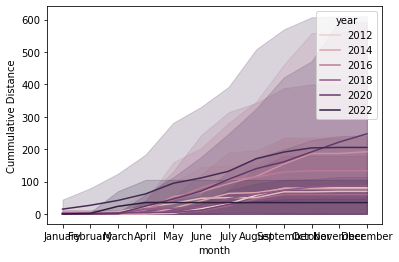

In [149]:
# Plotting cummulative distance by month
sns.lineplot(x='month', y='Cummulative Distance', data=grouped_by_year_and_month, hue='year')

In [ ]:
#Comverting start_loca-date to datetime
processed_data['start_date_local'] = pd.to_datetime(processed_data['start_date_local'])
processed_data['start_date_local'] = processed_data['start_date_local'].dt.strftime('%m-%d-%Y')
processed_data

In [ ]:
processed_data.columns

In [ ]:
###########################
# STRAVA LIFETIME SUMMARY #
###########################

# Total number of activities
start_date = processed_data.year.min()
burger_calories = 354
total_activities = processed_data.id.count()
num_rides = (processed_data.type == 'Ride').sum()
num_runs = (processed_data.type == 'Workout').sum()
distance_traveled = processed_data.distance.sum().astype(int)
earth_circumference = 24901 # earth circumference in miles 
perc_around_the_earth = (distance_traveled / earth_circumference)
total_kudos = processed_data.kudos_count.sum()
total_climbing = processed_data.total_elevation_gain.sum().astype(int)
power_output = processed_data.average_watts.sum()


print(f'Strava user since: {start_date}')
print(f'Total number of activities: {total_activities}')
print(f'Total distance traveled: {"{:,}".format(distance_traveled)} miles or {"{:.0%}".format(perc_around_the_earth)} of the earth circumference')
print(f'Total climbing: {"{:,}".format(total_climbing)} feet')


print(f'Number of Rides: {num_rides}')
print(f'Number of Runs: {num_runs}')


# Ratio of activities by type
processed_data['type'].value_counts(normalize=True)

# Breakdown of activities by type
processed_data['type'].value_counts()

# Total distance by activity type
total_by_activity = processed_data.groupby('type')['distance'].sum().sort_values(ascending=False)

In [ ]:
# Activities pie chart

grouped_by_type = processed_data.groupby('type').agg({'type': 'count'}).rename(columns={'type': 'total'}).sort_values('total', ascending=False).reset_index()
grouped_by_type.loc[grouped_by_type.total < 20, 'type'] = 'Other'

pie_df = grouped_by_type.groupby('type').agg({'total': 'sum'}).rename(columns={'total': 'total'}).reset_index()

breakdown_by_type = processed_data['type'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

explode = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
strava_color_palette = ['#45738F', '#FC4C02', '#3A18B0', '#FFAA06', '#F5674E']
textprops = {"fontsize":12, 'fontweight':'bold', 'color':'grey'}

plt.pie(pie_df.total, labels=pie_df.type, autopct=lambda p: format(p, '.1f') if p>1 else None, pctdistance=0.8, colors=strava_color_palette, textprops=textprops, startangle=30)
ax.axis('equal')
ax.add_artist(plt.Circle((0, 0), 0.6, color='white'))

for text in ax.texts:
    text.set_color('grey')


fig.show()

In [ ]:
pie_df

In [ ]:
grouped_by_type = processed_data.groupby('type').agg({'type': 'count'}).rename(columns={'type': 'total'}).sort_values('total', ascending=False).reset_index()
grouped_by_type.loc[grouped_by_type.total < 20, 'type'] = 'Other'

pie_df = grouped_by_type.groupby('type').agg({'total': 'sum'}).rename(columns={'total': 'total'}).reset_index()

activities = pie_df.type
breakdown_by_type = pie_df.total
import plotly.graph_objects as go
fig = go.Figure(data=[go.Pie(labels=activities, values=breakdown_by_type, hole=.6)])
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
# Activity Breakdown by type
# Chart of all activities by type

fig = px.bar(breakdown_by_type, y=breakdown_by_type.index, x=breakdown_by_type.values, text_auto='', orientation='h') # Plotly Express
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.update_layout(
    yaxis_title="",
    xaxis_title="Total Activities",
    font=dict(
        family="Arial",
        size=14,
    ),
    plot_bgcolor='white',
    paper_bgcolor='#FFFFFF',
    margin_l=0,
    margin_r=10,
    margin_t=0,
    margin_b=50,
    width=500,
    uniformtext_minsize=8, 
    uniformtext_mode='hide',
    hovermode=False,

)
fig.update_traces(marker_color='#FC4C02')
                  
fig.update_yaxes(showticklabels=True)
fig.update_xaxes(showticklabels=False)
fig.show()

In [ ]:
breakdown_by_type = list(processed_data['type'].value_counts())
activities = list(processed_data['type'].unique())
activities

In [ ]:
# Bar graph of breakdown by type
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.bar(breakdown_by_type.index, breakdown_by_type.values)

In [ ]:
# Grouping data by year, month and weekday
activities_df['cumulative_distance'] = activities_df.groupby(['year', 'month', 'weekday']).agg({'distance': 'cumsum'})
activities_df


In [ ]:
kjoule_to_cal = 0.239006 # 1 kjoule = 0.239006 calories
# Converting kjoule to calories
activities_df['calories'] = activities_df['kilojoules'] * kjoule_to_cal

In [ ]:
#################
# DATA ANALYSIS #
#################

# Total number of activities
start_date = activities_df.year.min()
burger_calories = 354
total_activities = activities_df.id.count()
total_calories = activities_df.calories.sum()
burgers_burned = total_calories / burger_calories



print(f'Total number of activities since {start_date}: {total_activities}')
print(f'Total calories burned: {total_activities} or {burgers_burned} burgers!')

# Ratio of activities by type
activities_df['type'].value_counts(normalize=True)

# Breakdown of activities by type
activities_df['type'].value_counts()

# Total distance by activity type
total_by_activity = activities_df.groupby('type')['distance'].sum().sort_values(ascending=False)

In [ ]:
activities_df.head()

In [ ]:
activities_df.columns

In [ ]:
total_by_activity

In [ ]:



# x=activities_df.groupby(['type'])['type'].count()
# y=len(activities_df)
# r=((x/y)).round(2)

# mf_ratio = pd.DataFrame(r).T
# mf_ratio

In [ ]:

fig, ax = plt.subplots(1,1,figsize=(6.5, 2.5))

ax.barh(mf_ratio.index, mf_ratio['Ride'], 
        color='#b20710', alpha=0.9, label='Male')
ax.barh(mf_ratio.index, mf_ratio['Run'], left=mf_ratio['Ride'], 
        color='#221f1f', alpha=0.9, label='Female')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
#ax.set_yticklabels(mf_ratio.index, fontfamily='serif', fontsize=11)


# movie percentage
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['Ride'][i]*100)}%", 
                   xy=(mf_ratio['Ride'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')

    ax.annotate("Ride", 
                   xy=(mf_ratio['Ride'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')
    
    
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['Run'][i]*100)}%", 
                   xy=(mf_ratio['Ride'][i]+mf_ratio['Run'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')
    ax.annotate("Run", 
                   xy=(mf_ratio['Ride'][i]+mf_ratio['Run'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')






# Title & Subtitle
fig.text(0.125,1.03,'Ride & Run distribution', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(0.125,0.92,'We see vastly more movies than Runs on Netflix.',fontfamily='serif',fontsize=12)  

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    


#ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.06))

# Removing legend due to labelled plot
ax.legend().set_visible(False)
plt.show()

In [ ]:
# Grouping by activity type
grouped_by_type = processed_data.groupby(['type', 'year', 'month']).agg({'Activity ID': 'count', 'Distance':'sum', 'Elapsed Time':'sum', 'Calories':'sum'}).reset_index()
rides = grouped_by_type[grouped_by_type['Activity Type'] == 'Ride']
rides.head()

In [ ]:
# Calculating cummulative sum of distance and elapsed time
rides['Cummulative Distance'] = rides.groupby(['Year']).agg({'Distance': 'cumsum'})
rides['Cummulative Calories'] = rides.groupby(['Year']).agg({'Calories': 'cumsum'})
rides.tail()

In [ ]:
fig = px.line(rides, x="Month", y="Cummulative Distance", color='Year', markers=True)
fig.show()

In [ ]:
grouped_by_bike = activies_df.groupby('Activity Gear').agg({'Distance':'sum'}).sort_values(by='Distance', ascending=False).reset_index()
grouped_by_bike

In [ ]:
fig = px.bar(grouped_by_bike, x='Activity Gear', y='Distance', color='Activity Gear')
fig

In [ ]:
# DIR_STRAVA = './data'
# strava_conv = StravaConverter(
#     dir_in=DIR_STRAVA
# )


# # # Step 2: Unzip the zipped files
# # strava_conv.unzip_activities()

# # Step 3: Add metadata to existing GPX files
# strava_conv.add_metadata_to_gpx()

# # Step 4: Convert FIT to GPX
# strava_conv.strava_fit_to_gpx()

In [ ]:
###########################
# UNSUPERVISED CLUSTERING #
###########################

